This is y_test: 
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0

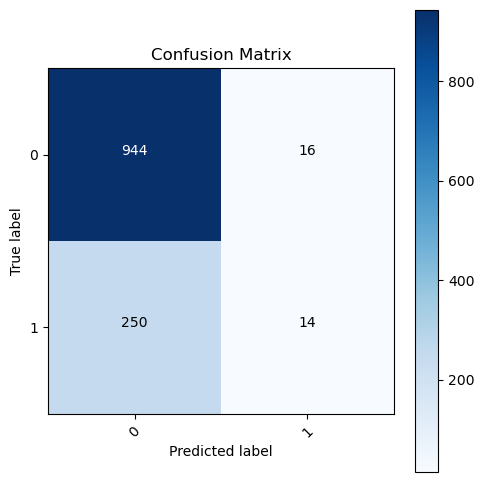

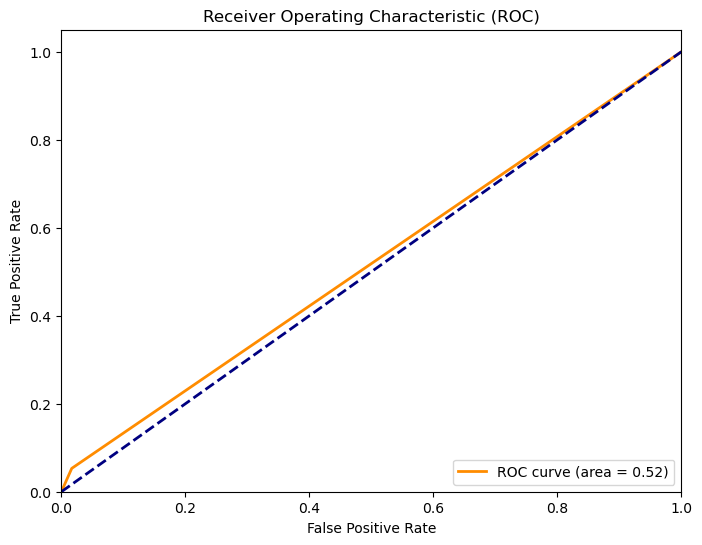

In [3]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score
import itertools

import numpy as np

class LogisticRegression:
    def __init__(self, learning_rate=0.005, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = (np.dot(X, self.weights) + self.bias)
        y_predicted = self._sigmoid(linear_model)* np.exp(250)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return y_predicted_cls
    
    def get_intercept(self):
        return self.bias

    def get_coefficients(self):
        return self.weights

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

def load_data(file_path):
    return pd.read_csv(file_path)

def sort_data_by_column(data, column):
    return data.sort_values(by=column, ascending=True)

def filter_data(data, num_start, prog_type, year_cred):
    filtro = (
        (data['Num Est'].astype(str).str.startswith(num_start)) & 
        (data['Prog Type'] == prog_type) & 
        (data['Año Cred'].isin(year_cred))
    )
    return data[filtro]

def identify_shared_data(data1, data2, shared_data, not_shared_data):
    for index, row in data1.iterrows():
        num_est = row['Num Est']
        if num_est in data2['Num Est'].values:
            shared_data.append(row)
        else:
            not_shared_data.append(row)

def merge_dataframes(df1, df2, how):
    return pd.merge(df1, df2, how=how)


def identify_dropout(data, graduated_students):
    dropout_list = []
    for index, row in data.iterrows():
        num_est = row['Num Est']
        if num_est not in graduated_students['Num Est'].values:
            dropout_list.append(row)
    return pd.DataFrame(dropout_list)

def rename_columns(data, column_names):
    return data.rename(columns=column_names)

def select_columns(data, columns_to_keep):
    return data[columns_to_keep]

def list_to_dataframe(data):
    return pd.DataFrame(data)

def accuracy_score(y_true, y_pred):
    """
    Calculates the accuracy score between the true labels and predicted labels.
 
    Parameters:
    - y_true: array-like of shape (n_samples,)
        The true labels.
    - y_pred: array-like of shape (n_samples,)
        The predicted labels.
 
    Returns:
    - float:
        The accuracy score.
 
    Raises:
    - ValueError:
        If the lengths of y_true and y_pred are not equal.
    """
 
    # Checking if the lengths of y_true and y_pred are equal
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred should be equal.")
 
    # Counting the number of correct predictions
    correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
 
    # Calculating the accuracy score
    accuracy = correct_predictions / len(y_true)
 
    return accuracy

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = [0, 1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# ROC Curve
def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

# Load data
data_2022 = load_data('student-data-2022-2023.csv')
data_2023 = load_data('student-data-2021-2022.csv')
students_graduated_2022 = sort_data_by_column(load_data('students_graduated.csv'), 'Num Est')

# Filter data
filtered_data_2022 = filter_data(data_2022, '841', 'Bachillerato', ['SEG', 'TER', 'CUA', '6TO', 'SNB', 'TNB', 'CNB', '6TN'])
filtered_data_2023 = filter_data(data_2023, '841', 'Bachillerato', ['SEG', 'TER', 'CUA', '6TO', 'SNB', 'TNB', 'CNB', '6TN'])

# Identify shared and non-shared data
shared_data = []
not_shared_data = []
identify_shared_data(filtered_data_2023, filtered_data_2022, shared_data, not_shared_data)
shared_data_df = list_to_dataframe(shared_data)
shared_data_df['dropout'] = 'N'
not_shared_data_df = list_to_dataframe(not_shared_data)

#Identify dropout
student_dropout_df = identify_dropout(not_shared_data_df, students_graduated_2022)
student_dropout_df['dropout'] = 'Y'

# Merge and select columns
training_model_data = merge_dataframes(shared_data_df, student_dropout_df, 'outer')
columns_to_keep = ['Num Est', 'Sexo', 'Prog Code', 'GPA', 'Muni', 'Año Cred', 'dropout']
training_model_data = select_columns(training_model_data, columns_to_keep)

# Rename columns
new_column_names = {
    'Num Est': 'student_id_PK',
    'Sexo': 'gender',
    'Prog Code': 'prog_code',
    'GPA': 'gpa',
    'Muni': 'town_origin',
    'Año Cred': 'year_cred',
}
training_model_data = rename_columns(training_model_data, new_column_names)

#Select the relevant columns and the objective column
features = training_model_data[['gender', 'prog_code', 'gpa', 'town_origin', 'year_cred']]
target = training_model_data['dropout']

# Create dummy variables for categorical features
features = pd.get_dummies(features, columns=['gender', 'prog_code', 'town_origin', 'year_cred'], drop_first=True)

# Using list comprehension to replace 'N' with 0 and 'Y' with 1
target = [0 if item == 'N' else 1 if item == 'Y' else item for item in target]
#target = pd.get_dummies(target, columns=['dropout'], drop_first=True)

#Training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.9, random_state=50)

# Train the Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

print("This is y_test: ")
print(y_test)
print()
print("This is y_pred: ")
print(y_pred)
print()

#Calculate the accuracy, precision and recall of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print()
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision: .2f}")
print()
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")
print()

# Get the intercept and coefficients
intercept = model.get_intercept()
coefficients = model.get_coefficients()

# Get the feature names
feature_names = features.columns

# Initialize the formula
formula = f"P(Y=1) = 1 / (1 + e^(-({intercept} + "

# Loop through coefficients and feature names to add terms to the formula
for i, (coef, feature_name) in enumerate(zip(coefficients, feature_names)):
    if i > 0:
        formula += f" + {coef:.4f}*{feature_name}"

# Complete the formula
formula += "))"
print("Logistic Formula:")
print(formula)

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC Curve
plot_roc_curve(y_test, y_pred)

plt.show()

This is y_test: 
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

This is y_pred: 
[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 

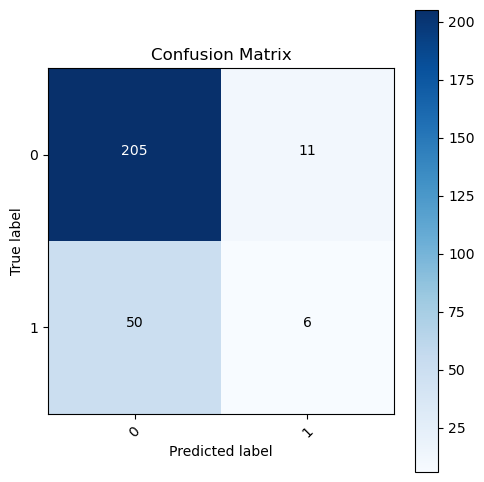

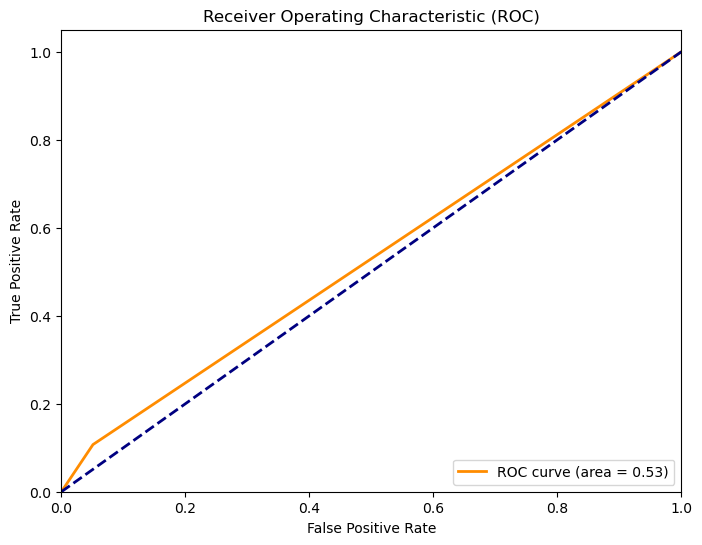

In [106]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, accuracy_score, recall_score
import itertools

import numpy as np

def load_data(file_path):
    return pd.read_csv(file_path)

def sort_data_by_column(data, column):
    return data.sort_values(by=column, ascending=True)

def filter_data(data, num_start, prog_type, year_cred):
    filtro = (
        (data['Num Est'].astype(str).str.startswith(num_start)) & 
        (data['Prog Type'] == prog_type) & 
        (data['Año Cred'].isin(year_cred))
    )
    return data[filtro]

def identify_shared_data(data1, data2, shared_data, not_shared_data):
    for index, row in data1.iterrows():
        num_est = row['Num Est']
        if num_est in data2['Num Est'].values:
            shared_data.append(row)
        else:
            not_shared_data.append(row)

def merge_dataframes(df1, df2, how):
    return pd.merge(df1, df2, how=how)


def identify_dropout(data, graduated_students):
    dropout_list = []
    for index, row in data.iterrows():
        num_est = row['Num Est']
        if num_est not in graduated_students['Num Est'].values:
            dropout_list.append(row)
    return pd.DataFrame(dropout_list)

def rename_columns(data, column_names):
    return data.rename(columns=column_names)

def select_columns(data, columns_to_keep):
    return data[columns_to_keep]

def list_to_dataframe(data):
    return pd.DataFrame(data)

# Load data
data_2022 = load_data('student-data-2022-2023.csv')
data_2023 = load_data('student-data-2021-2022.csv')
students_graduated_2022 = sort_data_by_column(load_data('students_graduated.csv'), 'Num Est')

# Filter data
filtered_data_2022 = filter_data(data_2022, '841', 'Bachillerato', ['SEG', 'TER', 'CUA', '6TO', 'SNB', 'TNB', 'CNB', '6TN'])
filtered_data_2023 = filter_data(data_2023, '841', 'Bachillerato', ['SEG', 'TER', 'CUA', '6TO', 'SNB', 'TNB', 'CNB', '6TN'])

# Identify shared and non-shared data
shared_data = []
not_shared_data = []
identify_shared_data(filtered_data_2023, filtered_data_2022, shared_data, not_shared_data)
shared_data_df = list_to_dataframe(shared_data)
shared_data_df['dropout'] = 'N'
not_shared_data_df = list_to_dataframe(not_shared_data)

#Identify dropout
student_dropout_df = identify_dropout(not_shared_data_df, students_graduated_2022)
student_dropout_df['dropout'] = 'Y'

# Merge and select columns
training_model_data = merge_dataframes(shared_data_df, student_dropout_df, 'outer')
columns_to_keep = ['Num Est', 'Sexo', 'Prog Code', 'GPA', 'Muni', 'Año Cred', 'dropout']
training_model_data = select_columns(training_model_data, columns_to_keep)

# Rename columns
new_column_names = {
    'Num Est': 'student_id_PK',
    'Sexo': 'gender',
    'Prog Code': 'prog_code',
    'GPA': 'gpa',
    'Muni': 'town_origin',
    'Año Cred': 'year_cred',
}
training_model_data = rename_columns(training_model_data, new_column_names)

#Select the relevant columns and the objective column
features = training_model_data[['gender', 'prog_code', 'gpa', 'town_origin', 'year_cred']]
target = training_model_data['dropout']

# Create dummy variables for categorical features
features = pd.get_dummies(features, columns=['gender', 'prog_code', 'town_origin', 'year_cred'], drop_first=True)

# Using list comprehension to replace 'N' with 0 and 'Y' with 1
target = [0 if item == 'N' else 1 if item == 'Y' else item for item in target]
#target = pd.get_dummies(target, columns=['dropout'], drop_first=True)

#Training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=50)

# Train the Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

print("This is y_test: ")
print(y_test)
print()
print("This is y_pred: ")
print(y_pred)
print()

#Calculate the precision of the model
accuracy2 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy2 * 100:.2f}%')
print()
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision: .2f}")
print()
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")
print()

# Get the intercept and coefficients
intercept = model.intercept_[0]
coefficients = model.coef_[0]

# Get the feature names
feature_names = features.columns

# Initialize the formula
formula = f"P(Y=1) = 1 / (1 + e^(-({intercept} + "

# Loop through coefficients and feature names to add terms to the formula
for i, (coef, feature_name) in enumerate(zip(coefficients, feature_names)):
    if i > 0:
        formula += f" + {coef:.4f}*{feature_name}"

# Complete the formula
formula += "))"
print("Logistic Formula:")
print(formula)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = [0, 1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# ROC Curve
def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC Curve
plot_roc_curve(y_test, y_pred)

plt.show()